In [ ]:
# Install libraries
!rm -fr /content/PCSE-Gym && cd /content/ && git clone https://github.com/BigDataWUR/PCSE-Gym.git
!cd /content/PCSE-Gym

!pip3 uninstall -y --quiet pcse
!rm -fr /content/pcse && cd /content/ && git clone https://github.com/ajwdewit/pcse.git
!cd /content/pcse && git apply /content/PCSE-Gym/notebooks/nitrogen-winterwheat/pcse.patch && pip3 install --quiet -e .

!pip3 install stable_baselines3
!pip3 install --upgrade --quiet cloudpickle pickle5

import sys
sys.path.insert(0, '/content/pcse')
sys.path.insert(0, '/content/PCSE-Gym/')
sys.path.insert(0, '/content/PCSE-Gym/notebooks/nitrogen-winterwheat')

In [2]:
# Some includes etc
import os
import gym
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import functools as ft
import matplotlib.lines as mlines
import numpy as np
import random
from bisect import bisect_left
import matplotlib

from helper import evaluate_policy, FindOptimum, get_test_tensor, plot_variable, get_ylim_dict, save_results, identity_line, compute_economic_reward
from wrapper import ReferenceEnv

costs_nitrogen = 10.0
all_years = [*range(1990, 2022)]
train_years = [year for year in all_years if year % 2 == 1]
test_years = [year for year in all_years if year % 2 == 0]
train_locations = [(52,5.5), (51.5,5), (52.5,6.0)]
test_locations= [(52,5.5), (48,0)]
location_to_label = {'52;5.5': 'NL', '48;0': 'FR'}
random.seed(42)

font = {'weight': 'bold', 'size': 14}
ax = {'titleweight': 'bold', 'titlesize': 14}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **ax)

colors = {'model':'tab:blue', 'fixed':'tab:orange', 'upperbound': 'red'}
markers = {'52;5.5':'o', '48;0':'^'}

sns.set_theme(font_scale=1.00)

inputdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat'
resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results'

In [3]:
# Evaluate policy
model_path = os.path.join(resultsdir,'models/model-1.zip')
stats_path = os.path.join(resultsdir,'models/model-1.pkl')
custom_objects = {"lr_schedule": lambda x: 0.0002, "clip_range": lambda x: 0.3}
model_cropgym = PPO.load(model_path, custom_objects=custom_objects, device='cuda', print_system_info=False)
if False: print(model_cropgym.policy)

crop_features = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
weather_features = ["IRRAD", "TMIN", "RAIN"]
action_features = []

rewards_model, results_model = {}, {}
for test_year in tqdm_notebook(all_years):
    for location in list(set(test_locations)):    
        env_pcse_evaluation = ReferenceEnv(crop_features=crop_features,
            action_features=action_features,
            weather_features=weather_features,
            costs_nitrogen=costs_nitrogen,
            years=test_year, locations=location,
            action_space=gym.spaces.Discrete(3), action_multiplier=2.0
            )
        env_pcse_evaluation = DummyVecEnv([lambda: env_pcse_evaluation])
        env_pcse_evaluation = VecNormalize.load(stats_path, env_pcse_evaluation)
        env_pcse_evaluation.training, env_pcse_evaluation.norm_reward = False, True
        my_key = (test_year, location)
        rewards_model[my_key], results_model[my_key] = evaluate_policy(model_cropgym, env_pcse_evaluation, amount=1)
        if False: print(f"{test_year} {location} {sum(results_model[my_key][0]['fertilizer'].values())} {sum(results_model[my_key][0]['reward'].values()):.2f}")
save_results(results_model, f'{os.path.join(inputdir, "RL-model.csv")}')

rewards_fixed, results_fixed = {}, {}
rewards_zero, results_zero = {}, {}
for test_year in tqdm_notebook(all_years):
  for location in list(set(test_locations)):
    my_key = (test_year, location)
    env_test = ReferenceEnv(costs_nitrogen=costs_nitrogen, years=test_year, locations=location)
    env_test = VecNormalize(DummyVecEnv([lambda: env_test]), norm_obs=True, norm_reward=True, clip_obs=10.,
                            clip_reward=50., gamma=1)
    rewards_fixed[my_key], results_fixed[my_key] = evaluate_policy('start-dump', env_test, amount=17.07)
    rewards_zero[my_key], results_zero[my_key] = evaluate_policy('start-dump', env_test, amount=0.00)
save_results(results_fixed, f'{os.path.join(inputdir, "fixed.csv")}')
save_results(results_zero, f'{os.path.join(inputdir, "zero.csv")}')

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/policies.py:458: UserWarning: As shared layers in the mlp_extractor are deprecated and will be removed in SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Available variables: ['DVS', 'TGROWTH', 'TGROWTHr', 'LAI', 'NUPTT', 'TRAN', 'TIRRIG', 'TNSOIL', 'TRAIN', 'TRANRF', 'NRF', 'GRF', 'TRUNOF', 'TDRAIN', 'TAGBM', 'TTRAN', 'WC', 'WLVD', 'WLVG', 'WRT', 'WSO', 'WST', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'RAIN', 'E0', 'ES0', 'ET0', 'WIND', 'action', 'fertilizer', 'reward', 'growth', 'prob', 'dvs', 'val']


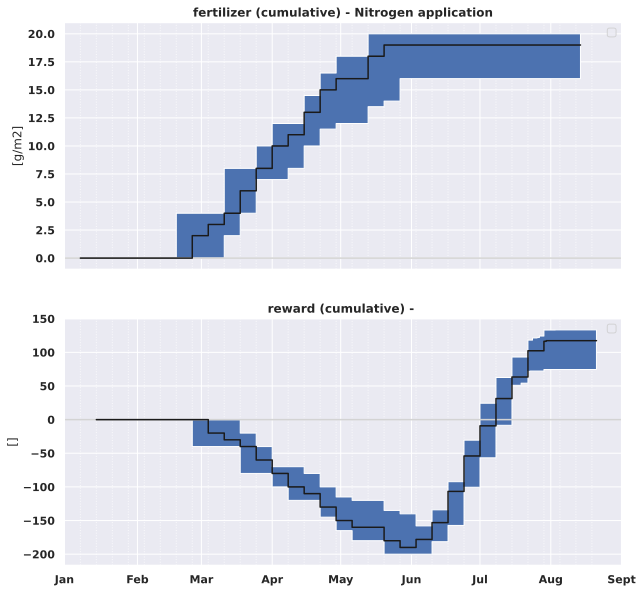

In [5]:
#Figure 3

# Plot crop variables and actions
%config InlineBackend.figure_format = 'svg'
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection
sns.set_theme(font_scale=1.00)

plot_results = results_model
all_variables = list(list(plot_results.values())[0][0].keys())
print(f'Available variables: {all_variables}')

plot_years = test_years
#subset_keys = [(year, a) for year in plot_years for a in test_locations]
subset_keys = [(year, (52,5.5)) for year in plot_years]
results_subset = {f'{subset_key}': plot_results[subset_key] for subset_key in subset_keys}

if True:
  plot_variables =  ['fertilizer', 'reward'] #, 'action', 'fertilizer','reward']
  figsize = (5*len(plot_variables), 5*len(plot_variables))
  fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=figsize)  
  for i, variable in enumerate(plot_variables):
    ax = axes if len(plot_variables) == 1 else axes[i]
    plot_variable(results_subset, variable=variable, cumulative_variables = ['fertilizer', 'reward', 'IRRAD','RAIN'], ax=ax, ylim=get_ylim_dict()[variable], plot_average=True, put_legend=True)

if False:
  plot_variables =  ['RAIN', 'action', 'fertilizer','reward']
  figsize = (1.5*len(plot_variables), 4*len(plot_variables))
  fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=figsize)  
  for i, variable in enumerate(plot_variables):
    plot_variable(results_subset, variable=variable, cumulative_variables = ['fertilizer', 'reward', 'IRRAD','RAIN'], ax=axes[i], ylim=get_ylim_dict()[variable], plot_average=False, put_legend=True)

<ipython-input-6-c15851995612>:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'location_x', 'year_x', 'RAIN_x', 'TMAX_x', 'TMIN_x', 'IRRAD_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how = 'outer'), dfs)
<ipython-input-6-c15851995612>:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'reward_x', 'ndays_x', 'TRANRF_x', 'WLL_x', 'WSO_x', 'nevents_x', 'TGROWTHr_x', 'DVS_x', 'fertilizer_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how = 'outer'), dfs)
<ipython-input-6-c15851995612>:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'location_x', 'RAIN_x', 'TMAX_x', 'year_x', 'val_x', 'TMIN_x', 'IRRAD_x'} in the result is deprecated and will raise a MergeError in

**NL**
std_model: 0.17 or 0.18
median_Ceres: 8.956 [8.96 / 8.90 (95% CI=8.41 9.14)[
median_SP: 8.72 [8.72 / 8.66 (95% CI=8.13 8.94)[
median_RL: 8.81 [8.81 / 8.78 (95% CI=8.24 9.13)]
median_RL-SP: 0.13 [0.14 / 0.17 (95% CI=-0.01 0.39) one-sided-p=0.0290]
**FR**
std_model: 0.17 or 0.20
median_Ceres: 8.599 [8.60 / 8.14 (95% CI=4.69 9.60)[
median_SP: 8.50 [8.50 / 8.12 (95% CI=5.80 9.13)[
median_RL: 8.45 [8.39 / 8.07 (95% CI=5.80 9.13)]
median_RL-SP: -0.04 [-0.03 / -0.03 (95% CI=-0.17 0.13) one-sided-p=0.6459]


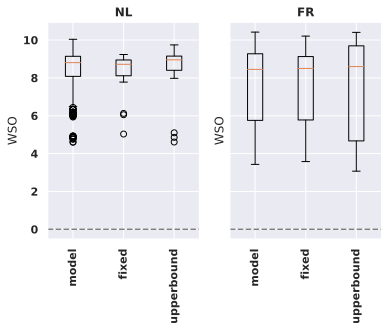

In [6]:
#Table 2 and 3

def report_mean_ci(boot_metric, report_p = False):
    median = np.median(boot_metric)
    ci_lower = np.quantile(boot_metric, 0.025)
    ci_upper = np.quantile(boot_metric, 0.975)
    mean = np.mean(boot_metric)
    return_string = f'{median:0.2f} / {mean:0.2f} (95% CI={ci_lower:0.2f} {ci_upper:0.2f})'
    if (report_p):
        boot_metric_sorted = np.sort(boot_metric)
        n_boot = len(boot_metric)
        idx = bisect_left(boot_metric_sorted, 0.0, hi=n_boot - 1)
        return_string = return_string + f' one-sided-p={(idx/n_boot):0.4f}'
    return return_string


def read_data(resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results', 
              csv_models={"baseline": "fixed.csv", "upperbound": "upperbound.csv", 
                          "model": ["model-1.csv", "model-3.csv", "model-5.csv", "model-7.csv", "model-9.csv", 
                                    "model-15.csv", "model-19.csv", "model-42.csv", "model-47.csv", "model-70.csv", 
                                    "model-74.csv", "model-75.csv", "model-79.csv", "model-88.csv", "model-99.csv"]}
              ):
  df_fixed = pd.read_csv(os.path.join(resultsdir, csv_models["baseline"]))
  df_upperbound = pd.read_csv(os.path.join(resultsdir, csv_models["upperbound"] ))
  df_models = [pd.read_csv(os.path.join(resultsdir, csv_model)) for csv_model in csv_models["model"]]
  import itertools
  dfs = list(itertools.chain([df_fixed, df_upperbound, *df_models]))
  suffix = list(itertools.chain(['_fixed', '_upperbound', *[f'_model_{i}' for i in range(len(df_models))]]))
  duplicate_cols = ['TMIN', 'TMAX', 'IRRAD', 'RAIN', 'year', 'location']

  for i, df in enumerate(dfs):
    dfs[i].columns = [str(col) if col in duplicate_cols else str(col) + suffix[i] for col in df.columns]
    if i>0:
      dfs[i].drop(columns=duplicate_cols, inplace=True)
    df_merged = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how = 'outer'), dfs)
  return df_merged

df_merged = read_data()

#append/amend some variables
filter_col = [col for col in df_merged if col.startswith('WSO')]
suffices = ([c.split('_', 1)[1] for c in filter_col])
for suffix in suffices:
    reward_economic = compute_economic_reward(df_merged[f'WSO_{suffix}'], df_merged[f'fertilizer_{suffix}'])
    df_merged[f'reward_economic_{suffix}'] = reward_economic
    df_merged['TAVG'] = (df_merged['TMIN'] + df_merged['TMAX']) / 2
    df_merged[f'fertilizer_{suffix}'] = 10.0 * df_merged[f'fertilizer_{suffix}']
    df_merged[f'WSO_{suffix}'] = 0.01 * df_merged[f'WSO_{suffix}']

df_merged = df_merged[df_merged.year % 2 == 0]
random.seed(42)    

#var = 'fertilizer'
#var = 'reward'
var = 'WSO'
name_var_model = [col for col in df_merged.columns if f'{var}_model' in col]
cols_var_model = [df_merged.columns.get_loc(col) for col in name_var_model]


fig_boxplot, ax_boxplot = plt.subplots(1,2,sharey=True)
if False: fig_hist, ax_hist = plt.subplots(1,2,sharex=True,sharey=True)
for i, location in enumerate (['52;5.5','48;0']):
    df_boot = df_merged.loc[df_merged["location"] == location]
    boot_model, boot_fixed, boot_delta_model_fixed, boot_upperbound = [], [], [], []
    print(f'**{location_to_label[location]}**')
    var_model=pd.concat([df_boot[col] for col in name_var_model]).to_numpy()
    var_fixed=df_boot[f'{var}_fixed'].to_numpy()
    var_upperbound=df_boot[f'{var}_upperbound'].to_numpy()
    data=np.array([var_model, var_fixed, var_upperbound], dtype=object)
    labels=['model', 'fixed', 'upperbound']
    ax_boxplot[i].boxplot(data)
    ax_boxplot[i].set_title(f'{location_to_label[location]}')
    ax_boxplot[i].set_xticks(1+np.arange(len(labels)))
    ax_boxplot[i].set_xticklabels(labels, rotation=90)
    ax_boxplot[i].set_ylabel(f'{var}')
    ax_boxplot[i].axhline(y=0.0, color='grey', linestyle='--', zorder=1)
    
    df_std = df_boot[name_var_model]
    df_std = df_std.sub(df_std.mean(axis=1), axis=0)
    print(f'std_model: {np.mean(df_boot[name_var_model].std(axis=1)):0.2f} or {df_std.values.std(ddof=1):0.2f}')

    n_observations=len(df_boot.index)
    n_boot=10000
    for b in range(n_boot):
        obs = random.choices(range(n_observations), k=n_observations)
        seed = random.choices(cols_var_model, k=n_observations)
        var_model = df_boot.values[obs, seed]
        var_upperbound = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_upperbound')]*n_observations]
        boot_upperbound.append(np.median(var_upperbound))
        var_fixed = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_fixed')]*n_observations]
        delta_model_fixed = var_model - var_fixed
        boot_model.append(np.median(var_model))
        boot_fixed.append(np.median(var_fixed))
        boot_delta_model_fixed.append(np.median(delta_model_fixed))
    
    median_Ceres = np.median(df_boot[f'{var}_upperbound'])
    median_SP = np.median(df_boot[f'{var}_fixed'])
    median_RL = np.median(pd.concat([df_boot[col] for col in name_var_model]).to_numpy())
    median_diff = np.median(pd.concat([df_boot[col] - df_boot[f'{var}_fixed'] for col in name_var_model]).to_numpy())

    print(f'median_Ceres: {median_Ceres:0.3f} [{report_mean_ci(boot_upperbound)}[')
    print(f'median_SP: {median_SP:0.2f} [{report_mean_ci(boot_fixed)}[')
    print(f'median_RL: {median_RL:0.2f} [{report_mean_ci(boot_model)}]')
    print(f'median_RL-SP: {median_diff:0.2f} [{report_mean_ci(boot_delta_model_fixed, True)}]')

    if False:
      data = pd.DataFrame(np.column_stack((boot_model, boot_upperbound)),columns=['model', 'upperbound'])
      data = pd.melt(data, value_vars=['model', 'upperbound'])
      sns.kdeplot(data=data, x="value", hue="variable", ax=ax_hist[i])

<ipython-input-7-fc4f3d6e70ce>:48: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


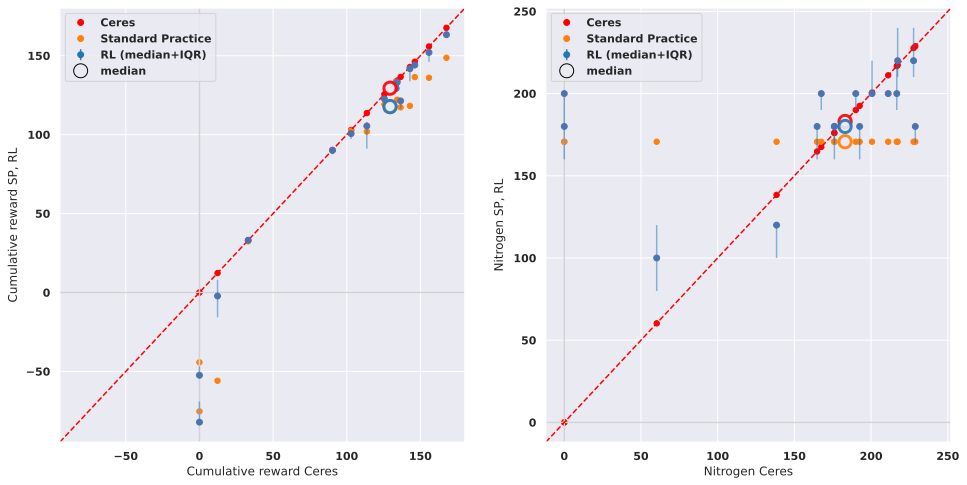

In [7]:
# Figure 2

%config InlineBackend.figure_format = 'svg'
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

sns.set_theme(font_scale=1.00)
do_annotate = False

markers = {'52;5.5':'o'}
#markers = {'52;5.5':'o', '48;0':'^'}
plots = {0:('reward_upperbound', 'reward'), 1:('fertilizer_upperbound', 'fertilizer')}
location=list(markers.keys())[0]

line = mlines.Line2D([], [], marker=markers[location], color=colors['model'], linestyle='None', markersize=6)
capline = mlines.Line2D([], [], marker=markers[location], color=colors['model'], linestyle='None', markersize=0)
barline = LineCollection(np.empty((2,2,2)))
RL= ErrorbarContainer((line, [capline], [barline]), has_xerr=False, has_yerr=True, label='RL (median+IQR)')

modes = ['upperbound', 'fixed', 'model']
fig, axes_scatter = plt.subplots(1, len(plots), figsize=(len(plots)*8,8), sharey='col', sharex='col')
ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[0]

legend_elements = [mlines.Line2D([], [], marker=markers[location], color=colors['upperbound'], linestyle='None', label='Ceres', markersize=6),
                   mlines.Line2D([], [], marker=markers[location], color=colors['fixed'], linestyle='None', label='Standard Practice', markersize=6),
                   RL,
                   mlines.Line2D([], [], marker=markers[location], color='black', linestyle='None', label='median', markersize=14, markerfacecolor=ax_scatter.get_facecolor())]

for p, (x_orig, y_orig) in plots.items():
    ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[p]
    title = f'{x_orig}/{y_orig}'
    for i, m in enumerate(modes):
        x = f'{x_orig}'
        y = f'{y_orig}_model_1' if m == 'model' else f'{y_orig}_{m}'
        r = df_merged[x].corr(df_merged[y])
        title = title + f'\n (r_{m}={r:0.2f})'
        for i, location in enumerate (list(markers.keys())):
            df_scatter = df_merged.loc[df_merged["location"] == location]
            r = df_scatter[x].corr(df_scatter[y])
            title = title + f' (r_{location_to_label[location]}={r:0.2f}) (n={len(df_scatter[x])})'
            if m == 'model':
                name_var_model = [col for col in df_scatter.columns if f'{y_orig}_model' in col]
                y_mean = df_scatter[name_var_model].mean(axis=1)
                y_median = np.median(df_scatter[name_var_model], axis=1)
                y_std = df_scatter[name_var_model].std(axis=1)
                q25, q75 = np.percentile(df_scatter[name_var_model], [25, 75], axis=1)
                asymmetric_error = np.array(list(zip(y_median-q25, q75-y_median))).T
                _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
                # loop through bars and caps and set the alpha value
                [bar.set_alpha(0.5) for bar in bars]
                [cap.set_alpha(0.5) for cap in caps]
            else:
                ax_scatter.scatter(df_scatter[x], df_scatter[y], s=30, color=colors[m], marker=markers[location])
            for index, row in df_scatter.iterrows():
                id = f"{row['year']}"
                if do_annotate: ax_scatter.annotate(id, (row[x], row[y]), fontsize=6, color=colors[m]).set_alpha(.7)
            ax_scatter.scatter(np.median(df_scatter[x]), np.median(df_scatter[y]), s=150, edgecolors=colors[m], marker=markers[location], facecolors=ax_scatter.get_facecolor(), linewidths=3, zorder=3).set_alpha(.9)
            if do_annotate: ax_scatter.annotate(f'{np.median(df_scatter[y]):0.2f}', (np.median(df_scatter[x]+1), np.median(df_scatter[y])+1), fontsize=6, color='black')
            
    identity_line(ax=ax_scatter, color=colors['upperbound'])
    ax_scatter.axvline(x=0, color='lightgrey', zorder=1)
    ax_scatter.axhline(y=0, color='lightgrey', zorder=1)
    ax_scatter.set_xlabel(f'{x.replace("fertilizer", "Nitrogen").replace("upperbound", "Ceres").replace("_", " ").replace("reward", "Cumulative reward")}')
    ax_scatter.set_ylabel(f'{y_orig.replace("fertilizer", "Nitrogen").replace("_", " ").replace("reward", "Cumulative reward")} SP, RL')
    ax_scatter.yaxis.set_label_coords(-.1, 0.5)
    ax_scatter.legend(handles=legend_elements, loc='upper left')
    
    low_x, high_x = ax_scatter.get_xlim()
    low_y, high_y = ax_scatter.get_ylim()
    low = min(low_x, low_y)
    high = max(high_x, high_y)
    ax_scatter.set_xlim(low, high)
    ax_scatter.set_ylim(low, high)
    title=''
fig.savefig(f'{resultsdir}/image-scatter-{y_orig}-{location_to_label[location]}.png')

<ipython-input-8-3c748f37ee0b>:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
<ipython-input-8-3c748f37ee0b>:71: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax_scatter.grid(b=True, which='major', color='w', linestyle='-')
<ipython-input-8-3c748f37ee0b>:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
<ipython-input-8-3c748f37ee0

/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-rain-nitrogen-NL.png
/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-rain-nitrogen-FR.png


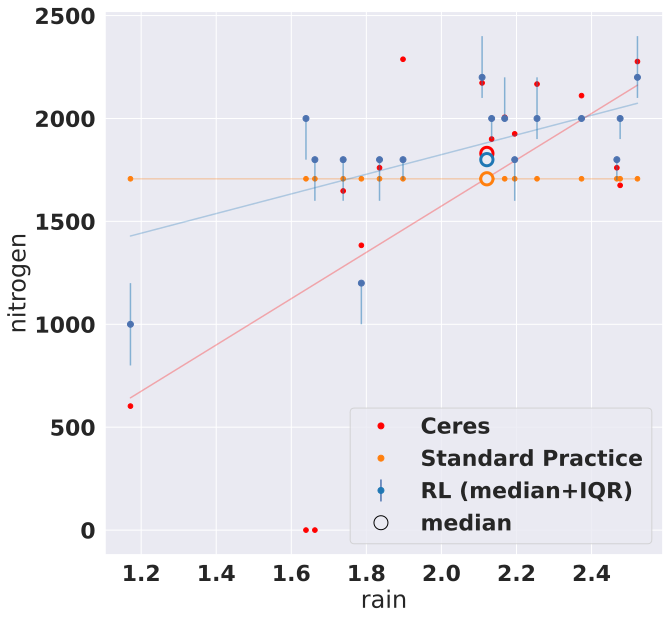

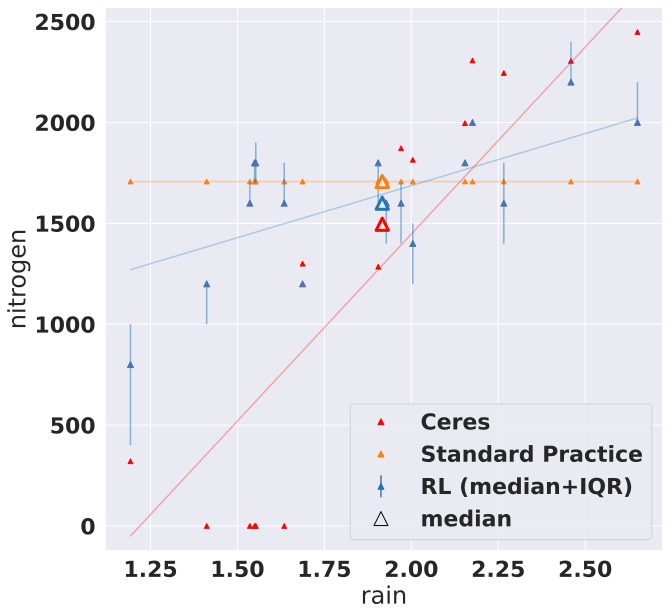

In [8]:
# Figure 4

from sklearn.linear_model import Ridge

%config InlineBackend.figure_format = 'svg'
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

sns.set_theme(font_scale=2.00)

df_merged[f'rain'] = 10.0*df_merged[f'RAIN']
filter_col = [col for col in df_merged if col.startswith('WSO')]
suffices = ([c.split('_', 1)[1] for c in filter_col])
for suffix in suffices:
    df_merged[f'nitrogen_{suffix}'] = 10.0*(df_merged[f'fertilizer_{suffix}'])

markers = {'52;5.5':'o', '48;0':'^'}
plots = {0:('rain', 'nitrogen')}
modes = ['upperbound', 'fixed', 'model']

for p, (x_orig, y_orig) in plots.items():
    for i, location in  enumerate (list(markers.keys())):
        line = mlines.Line2D([], [], marker=markers[location], color=colors['model'], linestyle='None', markersize=6)
        capline = mlines.Line2D([], [], marker=markers[location], color=colors['model'], linestyle='None', markersize=0)
        barline = LineCollection(np.empty((2,2,2)))
        RL= ErrorbarContainer((line, [capline], [barline]), has_xerr=False, has_yerr=True, label='RL (median+IQR)')
        legend_elements = [mlines.Line2D([], [], marker=markers[location], color=colors['upperbound'], linestyle='None', label='Ceres', markersize=6),
                   mlines.Line2D([], [], marker=markers[location], color=colors['fixed'], linestyle='None', label='Standard Practice', markersize=6),
                   RL,
                   mlines.Line2D([], [], marker=markers[location], color='black', linestyle='None', label='median', markersize=14, markerfacecolor=ax_scatter.get_facecolor())]
        df_scatter = df_merged.loc[df_merged["location"] == location]
        title = f'{x_orig}/{y_orig}_{m}'
        #ax_scatter = axes_scatter[i,p] if len(plots)> 1 else axes_scatter[i]
        fig, axes_scatter = plt.subplots(1, 1, figsize=(10,10))
        ax_scatter = axes_scatter
        
        for j, m in enumerate(modes):
            x = f'{x_orig}'
            y = f'{y_orig}_model_1' if m == 'model' else f'{y_orig}_{m}'
            
            if m == 'model':
                name_var_model = [col for col in df_scatter.columns if f'{y_orig}_model' in col]
                y_mean = df_scatter[name_var_model].mean(axis=1)
                y_median = np.median(df_scatter[name_var_model], axis=1)
                q25, q75 = np.percentile(df_scatter[name_var_model], [25, 75], axis=1)
                asymmetric_error = np.array(list(zip(y_median-q25, q75-y_median))).T
                _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
                [bar.set_alpha(0.5) for bar in bars]
                [cap.set_alpha(0.5) for cap in caps]
            else:
                y_median = df_scatter[y].values
                ax_scatter.scatter(df_scatter[x], y_median, s=22, color=colors[m], marker=markers[location])

            reg, = ax_scatter.plot([], [],color=colors[m], alpha=0.3)
            clf = Ridge(alpha=0.5)
            clf.fit(df_scatter[x].values.reshape(-1, 1), y_median.reshape(-1, 1))
            f = clf.predict
            reg.set_data([np.min(df_scatter[x]), np.max(df_scatter[x])], [f(np.min(df_scatter[x]).reshape(-1, 1)),f(np.max(df_scatter[x]).reshape(-1, 1))])

            do_annotate=False
            if do_annotate:
              df_scatter['y'] = y_median
              for index, row in df_scatter.iterrows():
                id = f"{row['year']}"
                ax_scatter.annotate(id, (row[x], row['y']), fontsize=6, color=colors[m]).set_alpha(.7)

            ax_scatter.scatter(np.median(df_scatter[x]), np.median(df_scatter[y]), s=150, edgecolors=colors[m], marker=markers[location], facecolors=ax_scatter.get_facecolor(), linewidths=3, zorder=3)

        ax_scatter.set_xlabel(f'{x_orig}')
        ax_scatter.set_ylabel(f'{y_orig}')
        ax_scatter.grid(b=True, which='major', color='w', linestyle='-')
        ax_scatter.legend(handles=legend_elements)
        #ax_scatter.set_xlim([1.0,2.75])
        #ax_scatter.set_ylim([-10,255])
        fig.savefig(f'{resultsdir}/image-scatter-{x_orig}-{y_orig}-{location_to_label[location]}.png')
        print(f'{resultsdir}/image-scatter-{x_orig}-{y_orig}-{location_to_label[location]}.png')

In [ ]:
# Let's have a look at some specifics of the training
log_dir = '/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/tensorboard_logs'
%load_ext tensorboard
%tensorboard --logdir $log_dir